In [1]:
import numpy as np
import scipy.stats as ss
import elfi
import pylab as plt
import os
import sys
sys.path.append(os.path.abspath(os.path.join('..')))
import pyabc

# Clinic Example
![](img/clinic.png)

In [14]:
def simulator(_lambda, debug=False, batch_size=1, random_state=None):
    _lambda = abs(_lambda)
    nr_doctors = 3
    opening_time = 9 * 60
    closing_time = 16 * 60
    patients_in_treatment = np.zeros(nr_doctors) # 0,1 first column, treatment time second column
    
    result = [
        [0], # nr_patients 
        [], # waiting_times
        [0] # closing time
    ]
    
    def treatment_time():
        return np.random.uniform(5,20)
    
    def next_patient(last):
        return last + np.random.exponential(1/_lambda)
    
    def create_patient_list():
        list_of_patients = []
        list_of_patients.append(next_patient(opening_time))
        while list_of_patients[-1] < closing_time:
            list_of_patients.append(next_patient(list_of_patients[-1]))
        
        return np.array(list_of_patients[:-1])
    
    list_of_patients = create_patient_list()
    N = list_of_patients.shape[0]
    result[0][0] = N
    result[1] = np.zeros(N)
    
    for i, arrival in enumerate(list_of_patients):
        if debug:
            print("%d. patient arrives at %.2f" % (i+1, arrival))
            print("doctor schedule: ", patients_in_treatment)
        
        doctor = np.argmin(patients_in_treatment)
        treatment_end = patients_in_treatment[doctor]
        # is any doctor free? T
        # This is the case when treatment time is 0 or treatment is done before next patient arrives
        if treatment_end == 0 or arrival > treatment_end:
            if debug:
                print("patient has not to wait")
            patients_in_treatment[doctor] = arrival + treatment_time() # treamtment lasts between 5 and 20 minutes
            
        else: 
            if debug:
                print("patient has to wait")
            waiting_time = treatment_end - arrival # patient has to wait
            result[1][i] = waiting_time
            patients_in_treatment[doctor] = treatment_end + treatment_time() # treatment lasts between 5 and 20 minutes
        
        if debug:
            print("treatment end: ",patients_in_treatment[doctor])
            print("waiting time: ", result[1][i])
            print("---------")
    
    result[2][0] = np.max(patients_in_treatment)
    
    return result

In [3]:
# Set the generating parameters that we will try to infer
lambda0 = 1/10

# Generate some dat9 (using a fixed seed here)
np.random.seed(1228)
y0 = simulator(lambda0)
print(y0)

[[49], array([  0.        ,   0.        ,   0.        ,   0.        ,
         0.42344354,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   4.51585521,   0.        ,
         4.34929369,   5.33611555,   4.79045358,  11.19269357,
        10.47966238,   6.52416327,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   5.97595535,   8.83547883,
         0.        ,   0.        ,   0.        ,   0.29101362,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,   0.        ]), [964.8378133280579]]


In [4]:
# summary statistics
def closing_time(y):
    return np.atleast_1d(y[2])

def nr_patients(y):
    return np.atleast_1d(y[0])

def nr_waiting_patients(y):
    return np.atleast_1d(np.sum(np.where(y[1] > 0, 1, 0)))

def mean(y):
    return np.atleast_1d(y[1].mean())

def var(y):
    return np.atleast_1d(y[1].var())

In [7]:
# prior over rate parameter
rate = pyabc.UniformPrior(0.01,1)

# Our PYABC

In [8]:
rej = pyabc.RejectionSampler(priors=[rate], simulator=simulator, 
                             summaries=[closing_time, nr_patients, nr_waiting_patients],
                             observation=y0)

In [9]:
rej.sample(nr_samples=1000, threshold=5)

Rejection sampler started with threshold: 5 and number of samples: 1000
Samples:   1000 - Threshold: 5.00 - Iterations:     259234 - Time:   293.53 s


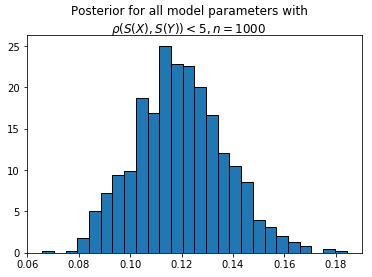

In [10]:
rej.plot_marginals()

In [15]:
smc = pyabc.SMCSampler(priors=[rate], simulator=simulator, 
                             summaries=[closing_time, nr_patients, nr_waiting_patients],
                             observation=y0)

In [16]:
smc.sample(nr_samples=1000, thresholds=[30,20,10,5])

SMC sampler started with thresholds: [30, 20, 10, 5] and number of samples: 1000
Rejection sampler started with threshold: 30 and number of samples: 1000
Iteration 0 completed
starting iteration[ 1 ]
Iteration 1 completed
starting iteration[ 2 ]
Iteration 2 completed
starting iteration[ 3 ]
Iteration 3 completed
Samples:   1000 - Thresholds: 5.00 - Iterations:      42548 - Time:    33.50 s


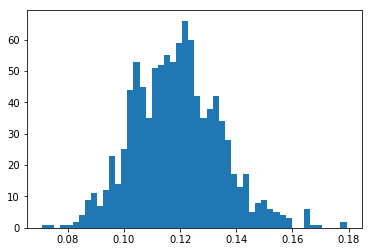

In [20]:
plt.hist(smc.Thetas, bins = 50)
plt.show()

# ELFI

In [13]:
# Prior
elfi.new_model() # important to reset, otherwise rerun the code will produce two nodes for S1, S2 and so on
rate = elfi.Prior('uniform', 0.01, 1)

# Add the simulator node and observed data to the model
#vectorized_simulator = elfi.tools.vectorize(simulator)
sim = elfi.Simulator(simulator, rate, observed=y0)

# Add summary statistics to the model
#S1 = elfi.Summary(mean, sim, name="mean")
#S2 = elfi.Summary(var, sim, name="var")
S3 = elfi.Summary(closing_time, sim, name="closing time")
S4 = elfi.Summary(nr_patients, sim, name="total patients")
S5 = elfi.Summary(nr_waiting_patients, sim, name="nr of patients waiting")

d4 = elfi.Distance('euclidean', S3, S4, S5)

In [14]:
rej = elfi.Rejection(d4, batch_size=1)
res = rej.sample(1000, threshold=10)
print(res)

Method: Rejection
Number of samples: 1000
Number of simulations: 45876
Threshold: 10
Sample means: rate: 0.118



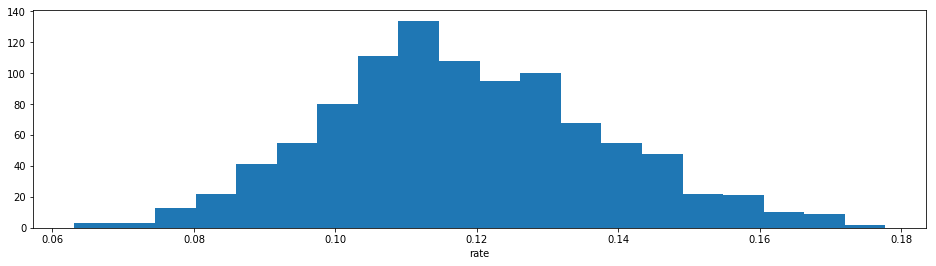

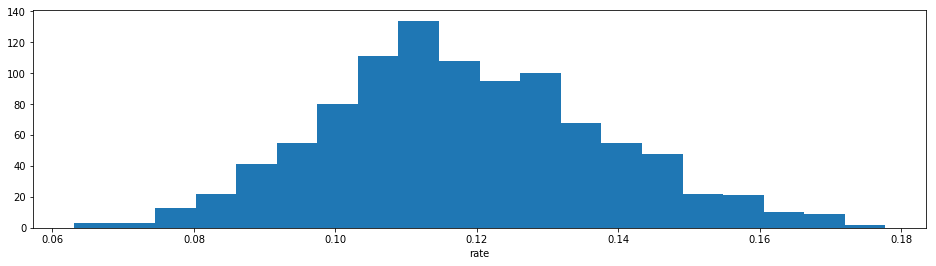

In [16]:
res.plot_marginals()
plt.show()